In [3]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm
# market_data = pd.read_parquet('data/US/test_mkt_data.pq')
# GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/test_adv_table.pq')
# market_data.dropna().sample(5)

In [4]:
market_features = pd.read_parquet('data/US/market_features.pq')
R = market_features['daily_returns'].unstack()

In [5]:
open = market_data['open'].unstack()
low = market_data['low'].unstack()
high = market_data['high'].unstack()
close = market_data['close'].unstack()

NameError: name 'market_data' is not defined

In [ ]:
div_open_close = open / close 
minus_high_low = high - low
minus_low_close = low - close
div = minus_low_close / minus_high_low
mult = div * div_open_close
mult

Ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABK,ABMD,ABT,...,XRX,XTO,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.437497,-0.180973,NaN,NaN,-0.887495,NaN,-0.622792,-0.307377,0.000000,-0.201494,...,-0.572686,-0.510487,NaN,-0.914335,-0.172284,NaN,-0.211931,-0.385711,NaN,NaN
2000-01-04,-0.434633,-0.663592,NaN,NaN,-0.146744,NaN,-0.625777,-0.396262,-0.562573,-0.253318,...,-0.104878,-0.209779,NaN,-0.018047,-0.379387,NaN,-0.780493,-0.129290,NaN,NaN
2000-01-05,-0.354036,-0.859540,NaN,NaN,-0.132806,NaN,-0.624037,-0.493190,-0.805729,-0.494670,...,-0.948454,-0.985562,NaN,-0.644128,-0.500133,NaN,-0.890691,-0.771429,NaN,NaN
2000-01-06,-0.496988,-0.040530,NaN,NaN,0.000000,NaN,-0.787596,-0.455438,-0.907650,-0.883603,...,-0.661404,-0.728951,NaN,-0.152789,-0.143298,NaN,-0.052892,-0.432870,NaN,NaN
2000-01-07,-0.785866,-0.027149,NaN,NaN,-0.705154,NaN,-0.884862,-0.498779,-0.547355,-0.555300,...,-0.723603,-0.697124,NaN,-0.886556,-0.227361,NaN,-0.429191,-0.334110,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,-0.316486,-0.383987,-0.424364,-0.054777,-0.243147,-0.452590,NaN,NaN,NaN,-0.193620,...,-0.686839,NaN,-0.274550,NaN,-0.538543,-0.008681,-0.795309,-0.272771,NaN,-0.624062
2024-02-27,-0.721237,-0.808677,-0.553811,-0.940306,-0.698230,-0.787266,NaN,NaN,NaN,-0.930356,...,-0.551940,NaN,-0.566511,NaN,-0.263384,-0.296504,-0.200887,-0.379536,NaN,-0.945557
2024-02-28,-0.190885,-0.616409,-0.551962,-0.454449,-0.434030,-0.373846,NaN,NaN,NaN,-0.924240,...,-0.340007,NaN,-0.351343,NaN,-0.914710,-0.186080,-0.580035,-0.103509,NaN,-0.832620


In [ ]:
signal =  np.log(1 +mult**3)[P].ffill()[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.25] =None
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).dropna(axis=0,how = 'all').sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)

NameError: name 'np' is not defined

<Axes: xlabel='Date'>

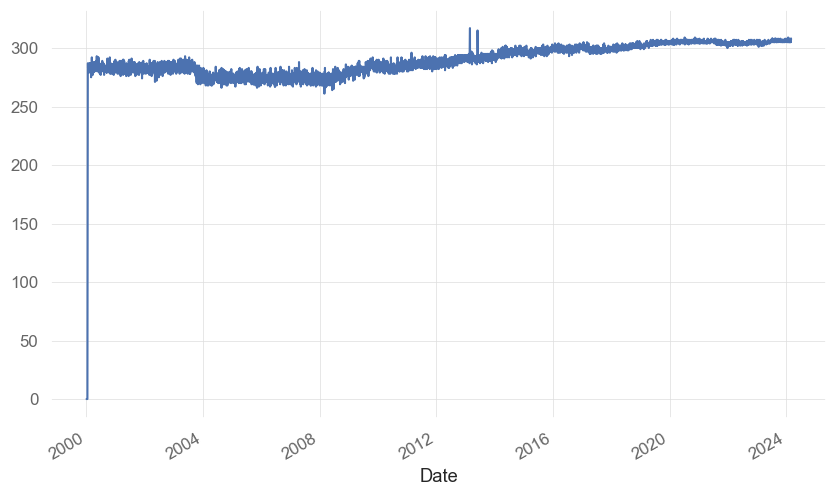

In [221]:
signal.count(1).plot()